#Introduction
We have the Indian Premier League data from 2008 to 2016. We have two files to begin with. 
Matches - giving us details of each match played.
Deliveries - all the deliveries in all the matches put together. 
We would work on these two files to extract data on each match, batsmen and bowlers.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

matches = pd.read_csv('matches.csv')
matches["type"] = "pre-qualifier"
for year in range(2008, 2017):
   final_match_index = matches[matches['season']==year][-1:].index.values[0]
   matches = matches.set_value(final_match_index, "type", "final")
   matches = matches.set_value(final_match_index-1, "type", "qualifier-2")
   matches = matches.set_value(final_match_index-2, "type", "eliminator")
   matches = matches.set_value(final_match_index-3, "type", "qualifier-1")

matches.groupby(["type"])["id"].count()
matches.head(2)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,type
0,1,2008,Bangalore,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN,pre-qualifier
1,2,2008,Chandigarh,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN,pre-qualifier


In [2]:
deliveries = pd.read_csv('deliveries.csv')
deliveries.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,1,SC Ganguly,BB McCullum,P Kumar,0,...,0,1,0,0,0,1,1,NaN,NaN,NaN
1,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,2,BB McCullum,SC Ganguly,P Kumar,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN


##Add team score and team extra columns for each match, each inning.

In [3]:
team_score = deliveries.groupby(['match_id', 'inning'])['total_runs'].sum().unstack().reset_index()
team_score.columns = ['match_id', 'Team1_score', 'Team2_score', 'Team1_superover_score', 'Team2_superover_score']
matches_agg = pd.merge(matches, team_score, left_on = 'id', right_on = 'match_id', how = 'outer')

team_extras = deliveries.groupby(['match_id', 'inning'])['extra_runs'].sum().unstack().reset_index()
team_extras.columns = ['match_id', 'Team1_extras', 'Team2_extras', 'Team1_superover_extras', 'Team2_superover_extras']
matches_agg = pd.merge(matches_agg, team_extras, on = 'match_id', how = 'outer')

#Reorder the columns to make the data more readable
cols = ['match_id', 'season','city','date','team1','team2', 'toss_winner', 'toss_decision', 'result', 'dl_applied', 'winner', 'Team1_score','Team2_score', 'win_by_runs', 'win_by_wickets', 'Team1_extras', 'Team2_extras', 'Team1_superover_score', 'Team2_superover_score', 'Team1_superover_extras', 'Team2_superover_extras', 'player_of_match', 'type', 'venue', 'umpire1', 'umpire2', 'umpire3']
matches_agg = matches_agg[cols]
matches_agg.head(2)

,match_id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,...,Team1_superover_score,Team2_superover_score,Team1_superover_extras,Team2_superover_extras,player_of_match,type,venue,umpire1,umpire2,umpire3
0,1,2008,Bangalore,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,...,NaN,NaN,NaN,NaN,BB McCullum,pre-qualifier,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN
1,2,2008,Chandigarh,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,...,NaN,NaN,NaN,NaN,MEK Hussey,pre-qualifier,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN


##Batsmen aggregates (Runs, Balls, 4s, 6s, SR)

In [4]:
batsman_grp = deliveries.groupby(["match_id", "inning", "batting_team", "batsman"])
batsmen = batsman_grp["batsman_runs"].sum().reset_index()

# Ignore the wide balls.
balls_faced = deliveries[deliveries["wide_runs"] == 0]
balls_faced = balls_faced.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()
balls_faced.columns = ["match_id", "inning", "batsman", "balls_faced"]
batsmen = batsmen.merge(balls_faced, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")

fours = deliveries[ deliveries["batsman_runs"] == 4]
sixes = deliveries[ deliveries["batsman_runs"] == 6]

fours_per_batsman = fours.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()
sixes_per_batsman = sixes.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()

fours_per_batsman.columns = ["match_id", "inning", "batsman", "4s"]
sixes_per_batsman.columns = ["match_id", "inning", "batsman", "6s"]

batsmen = batsmen.merge(fours_per_batsman, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")
batsmen = batsmen.merge(sixes_per_batsman, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")
batsmen['SR'] = np.round(batsmen['batsman_runs'] / batsmen['balls_faced'] * 100, 2)

for col in ["batsman_runs", "4s", "6s", "balls_faced", "SR"]:
    batsmen[col] = batsmen[col].fillna(0)

dismissals = deliveries[ pd.notnull(deliveries["player_dismissed"])]
dismissals = dismissals[["match_id", "inning", "player_dismissed", "dismissal_kind", "fielder"]]
dismissals.rename(columns={"player_dismissed": "batsman"}, inplace=True)
batsmen = batsmen.merge(dismissals, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")

batsmen = matches[['id','season']].merge(batsmen, left_on = 'id', right_on = 'match_id', how = 'left').drop('id', axis = 1)
batsmen.head(2)

,season,match_id,inning,batting_team,batsman,batsman_runs,balls_faced,4s,6s,SR,dismissal_kind,fielder
0,2008,1,1,Kolkata Knight Riders,BB McCullum,158,73.0,10.0,13.0,216.44,NaN,NaN
1,2008,1,1,Kolkata Knight Riders,DJ Hussey,12,12.0,1.0,0.0,100.00,caught,CL White


##Bowler Aggregates

In [5]:
bowler_grp = deliveries.groupby(["match_id", "inning", "bowling_team", "bowler", "over"])
bowlers = bowler_grp["total_runs", "wide_runs", "bye_runs", "legbye_runs", "noball_runs"].sum().reset_index()

bowlers["runs"] = bowlers["total_runs"] - (bowlers["bye_runs"] + bowlers["legbye_runs"])
bowlers["extras"] = bowlers["wide_runs"] + bowlers["noball_runs"]

del( bowlers["bye_runs"])
del( bowlers["legbye_runs"])
del( bowlers["total_runs"])

dismissal_kinds_for_bowler = ["bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]
dismissals = deliveries[deliveries["dismissal_kind"].isin(dismissal_kinds_for_bowler)]
dismissals = dismissals.groupby(["match_id", "inning", "bowling_team", "bowler", "over"])["dismissal_kind"].count().reset_index()
dismissals.rename(columns={"dismissal_kind": "wickets"}, inplace=True)

bowlers = bowlers.merge(dismissals, left_on=["match_id", "inning", "bowling_team", "bowler", "over"], 
                        right_on=["match_id", "inning", "bowling_team", "bowler", "over"], how="left")
bowlers["wickets"] = bowlers["wickets"].fillna(0)

bowlers_over = bowlers.groupby(['match_id', 'inning', 'bowling_team', 'bowler'])['over'].count().reset_index()
bowlers = bowlers.groupby(['match_id', 'inning', 'bowling_team', 'bowler']).sum().reset_index().drop('over', 1)
bowlers = bowlers_over.merge(bowlers, on=["match_id", "inning", "bowling_team", "bowler"], how = 'left')
bowlers['Econ'] = np.round(bowlers['runs'] / bowlers['over'] , 2)
bowlers = matches[['id','season']].merge(bowlers, left_on = 'id', right_on = 'match_id', how = 'left').drop('id', axis = 1)

bowlers.head(2)

,season,match_id,inning,bowling_team,bowler,over,wide_runs,noball_runs,runs,extras,wickets,Econ
0,2008,1,1,Royal Challengers Bangalore,AA Noffke,4,5,0,40,5,1.0,10.0
1,2008,1,1,Royal Challengers Bangalore,CL White,1,2,0,24,2,0.0,24.0


##Team wins in home city vs other cities
Each team plays two matches against the other teams, one in its home city and other in the home city of the opposite team. It would be interesting see if playing in home city increases a teams chances of a win.

In [6]:
#No of wins by team and season in each city
x, y = 2008, 2017
while x < y:
    wins_percity = matches_agg[matches_agg['season'] == x].groupby(['winner', 'city'])['match_id'].count().unstack()
    plot = wins_percity.plot(kind='bar', stacked=True, title="Team wins in different cities\nSeason "+str(x), figsize=(7, 5))
    sns.set_palette("Paired", len(matches_agg['city'].unique()))
    plot.set_xlabel("Teams")
    plot.set_ylabel("No of wins")
    plot.legend(loc='best', prop={'size':8})
    x+=1

##Plot the performance of top 5 batsmen over seasons
V.Kohli show a steady improvement over season and C. Gayle  and SK Raina show a slump 

In [7]:
batsman_runsperseason = batsmen.groupby(['season', 'batting_team', 'batsman'])['batsman_runs'].sum().reset_index()
batsman_runsperseason = batsman_runsperseason.groupby(['season', 'batsman'])['batsman_runs'].sum().unstack().T
batsman_runsperseason['Total'] = batsman_runsperseason.sum(axis=1) #add total column to find batsman with the highest runs
batsman_runsperseason = batsman_runsperseason.sort_values(by = 'Total', ascending = False).drop('Total', 1)
ax = batsman_runsperseason[:5].T.plot()

##Percentage of total runs scored through boundaries for each batsman
The average for top batsmen is around 58-60% with exception of CH Gayle at 76%. Interestingly, MS Dhoni who is known for helicopter shots(6s) gets close to 45% of his runs through singles

In [8]:
batsman_runs = batsmen.groupby(['batsman'])['batsman_runs', '4s', '6s'].sum().reset_index()
batsman_runs['4s_6s'] = batsman_runs['4s'] * 4 + batsman_runs['6s'] * 6
batsman_runs['pct_boundaries'] = np.round(batsman_runs['4s_6s'] / batsman_runs['batsman_runs'] * 100, 2)
batsman_runs = batsman_runs.sort_values(by = 'batsman_runs', ascending = False)
batsman_runs[:10].plot(x= 'batsman', y = 'pct_boundaries', kind = 'bar')

##Performance of top bowlers over seasons
Malinga is the highest wicket taken in IPL so far

In [9]:
bowlers_wickets = bowlers.groupby(['bowler'])['wickets'].sum()
bowlers_wickets.sort_values(ascending = False, inplace = True)
bowlers_wickets[:10].plot(x= 'bowler', y = 'runs', kind = 'barh', colormap = 'Accent')

##Player of the match
See who has won the Player of the match award maximum number of times

In [11]:
matches['player_of_match'].value_counts()[:10].plot(kind = 'bar')

## Impact of toss on the match outcome

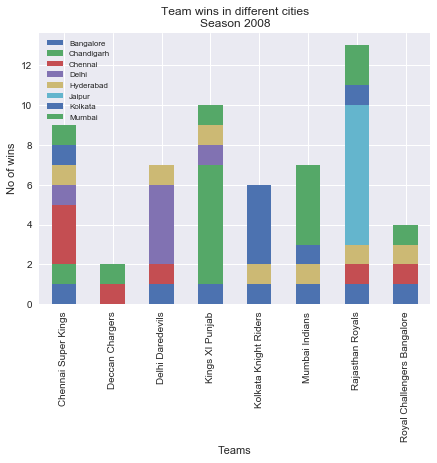

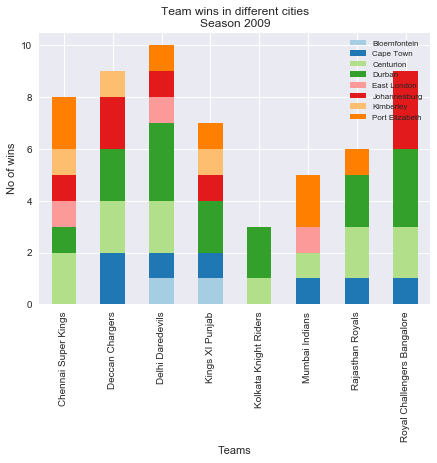

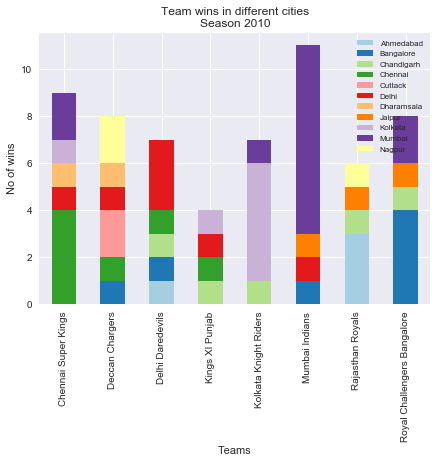

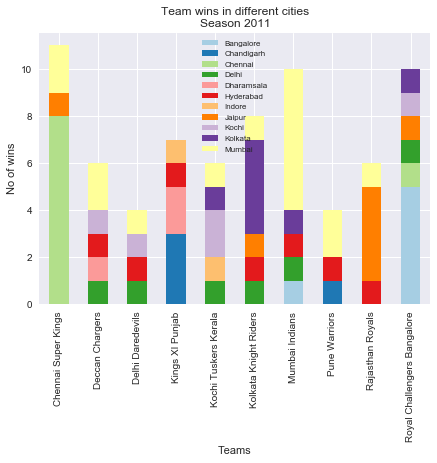

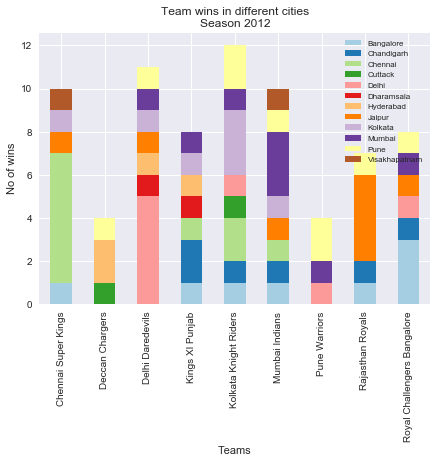

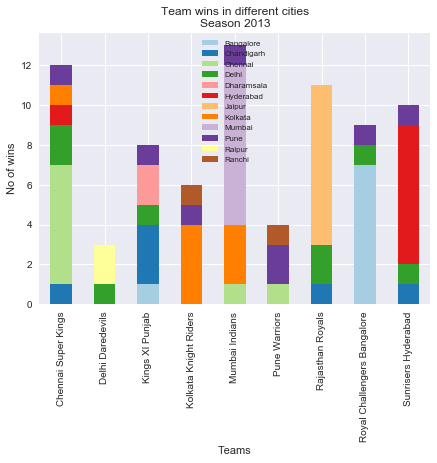

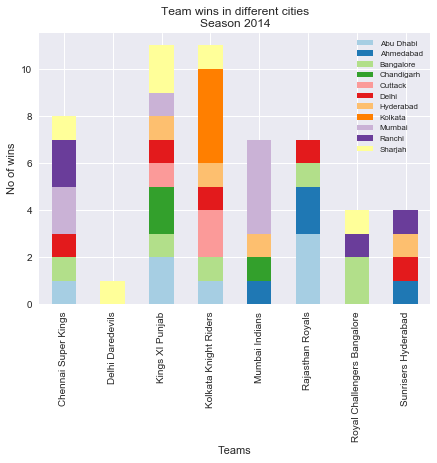

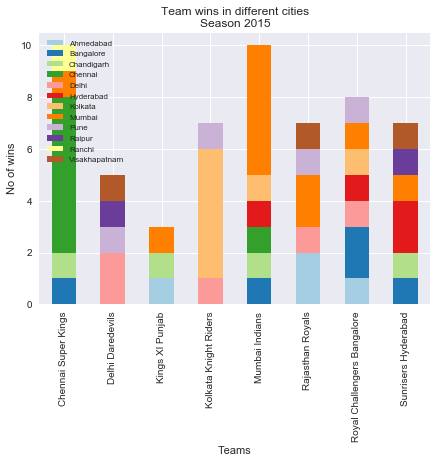

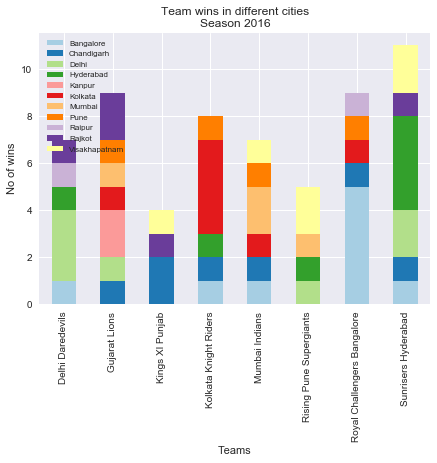

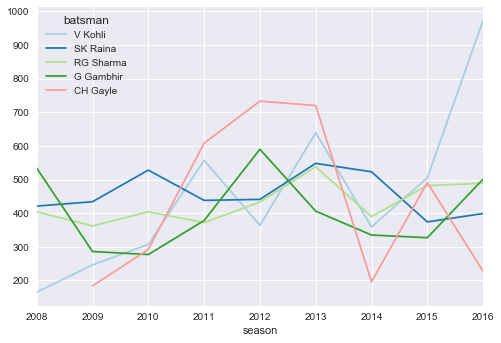

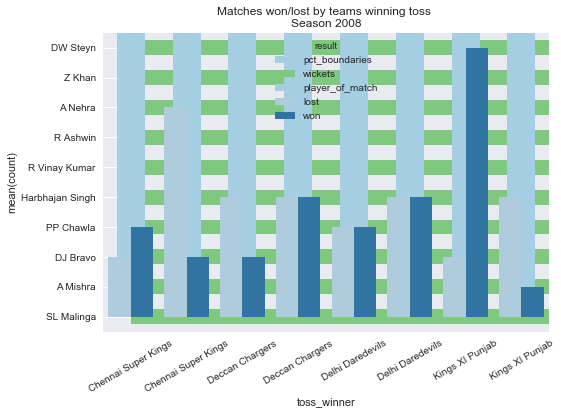

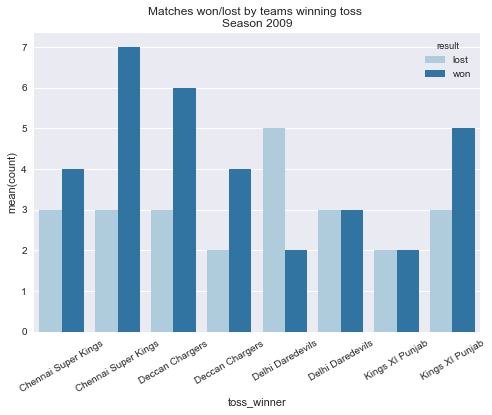

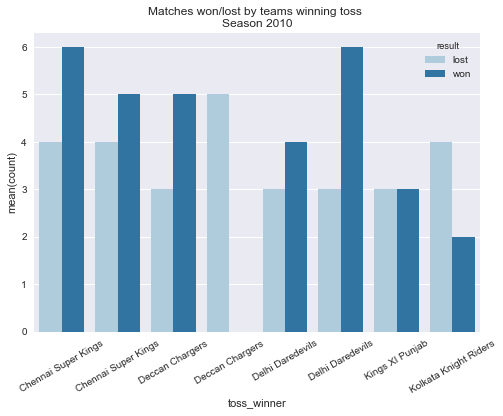

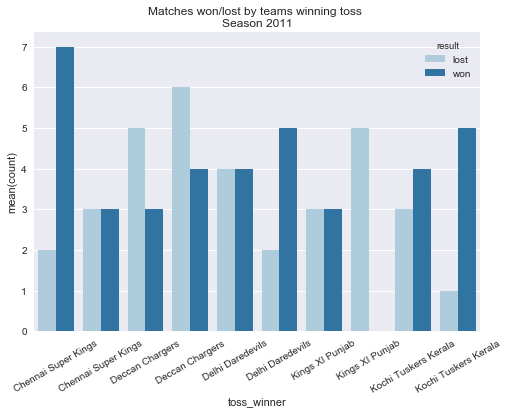

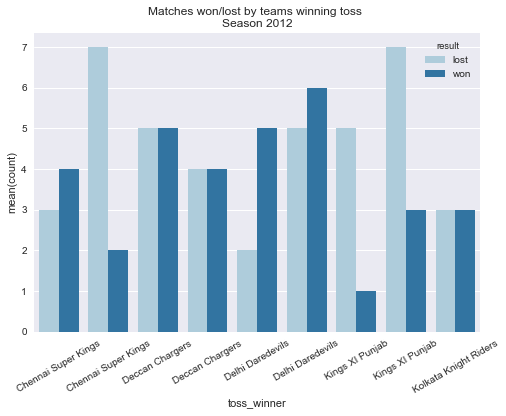

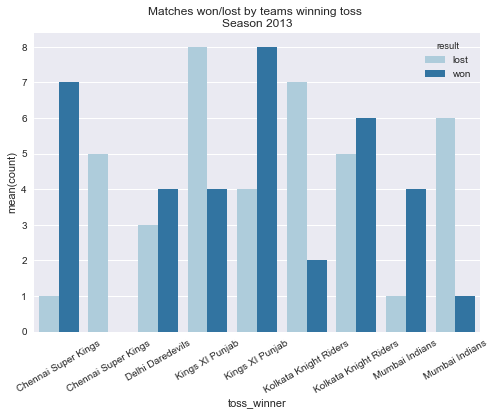

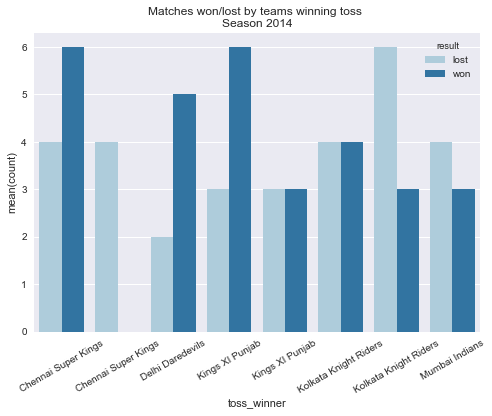

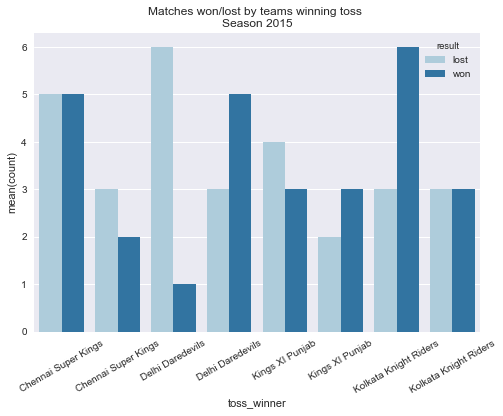

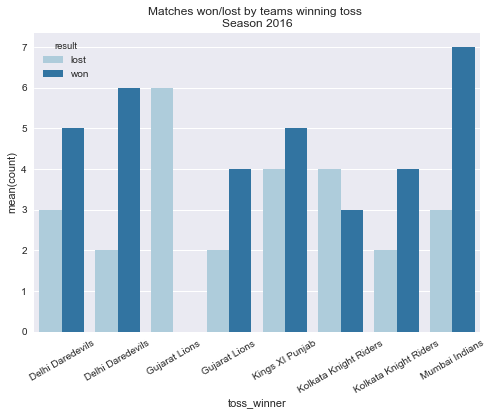

In [12]:
toss = matches_agg.groupby(['season', 'toss_winner']).winner.value_counts().reset_index(name = 'count')
toss['result'] = np.where(toss.toss_winner == toss.winner, 'won', 'lost')
toss_result = toss.groupby(['season', 'toss_winner','result'])['count'].sum().reset_index()

for x in range(2008, 2017, 1):
    toss_result_x = toss_result[toss_result['season'] == x]
    plot = sns.barplot(x="toss_winner", y="count", hue="result", data=toss_result_x)
    plot.set_title('Matches won/lost by teams winning toss \nSeason ' +str(x))
    plot.set_xticklabels(toss_result_x['toss_winner'],rotation=30)
    plt.show()
    x+=1